---
title: "Unit 2: Exploring EMIT data"
---

:::{tip}
This unit is based on the tutorial available [here](https://earth.jpl.nasa.gov/emit/data/trainings/)
:::

## EMIT data

EMIT is a NASA  imaging spectrometer installed on the International Space Station (ISS). EMIT measures radiance between 380 and 2500 nanometers, with an approximate 7 nm bandpass. Data are collected in a swath that is approximately 75 km wide at the equator, with an approximate ground sampling distance of 60 m. 

EMIT is an useful tool for mapping out greenhouse gases, including methane, carbon dioxide, and water vapor. 

The Level 2A data product contains estimated surface reflectance, uncertainty, and mask data. In addition, the geolocation of all pixel centers is included as well as the calculation of observation geometry and illumination angles on a pixel-by-pixel basis.

## Run me first

First of all, run the following cell to initialize the API.

In [131]:
import ee

# Trigger the authentication flow.
ee.Authenticate(auth_mode='localhost')

# Initialize the library.
ee.Initialize(project='ee-ializarazos')

In [132]:
import geemap
geemap.ee_initialize() 
from geemap import cartoee
import matplotlib.pyplot as plt

## Getting started with EMIT data

See https://lpdaac.usgs.gov/documents/1571/EMITL2A_ATBD_v1.pdf 



In [133]:
# Agriculture location of interest
pt_ag = ee.Geometry.Point([-74.3822, 10.8689])

In [134]:
# Initial date of interest (inclusive).
start_date = '2025-01-01'

# Final date of interest (exclusive).
end_date = '2025-12-31'

In [135]:
# Import the intented Image Collection.
# We will use EMIT Surface Reflectance Product
emit = ee.ImageCollection("NASA/EMIT/L2A/RFL").filterDate(start_date , end_date).filterBounds(pt_ag);


In [136]:
print(emit)  #Explore data structure 

ee.ImageCollection({
  "functionInvocationValue": {
    "functionName": "Collection.filter",
    "arguments": {
      "collection": {
        "functionInvocationValue": {
          "functionName": "Collection.filter",
          "arguments": {
            "collection": {
              "functionInvocationValue": {
                "functionName": "ImageCollection.load",
                "arguments": {
                  "id": {
                    "constantValue": "NASA/EMIT/L2A/RFL"
                  }
                }
              }
            },
            "filter": {
              "functionInvocationValue": {
                "functionName": "Filter.dateRangeContains",
                "arguments": {
                  "leftValue": {
                    "functionInvocationValue": {
                      "functionName": "DateRange",
                      "arguments": {
                        "end": {
                          "constantValue": "2025-12-31"
                        },
   

In [137]:
## Select image and bands of interest

In [138]:
img = emit.first()
img = img.select(ee.List.sequence(0, 578))
img = img.set('system:time_start', img.get('system:time_start'))
                

In [139]:
##print(img.bandNames())

## Let's plot the EMIT Image

In [140]:
true_emit = {
  "bands": ["reflectance_34","reflectance_20","reflectance_10"],
  "min": 0.009,
  "max": 0.29,
  "gamma": 2.5,
};

Map = geemap.Map(center=(10.8689, -74.3822), zoom=8)

Map.addLayer(img, true_emit, "01. EMIT true color")

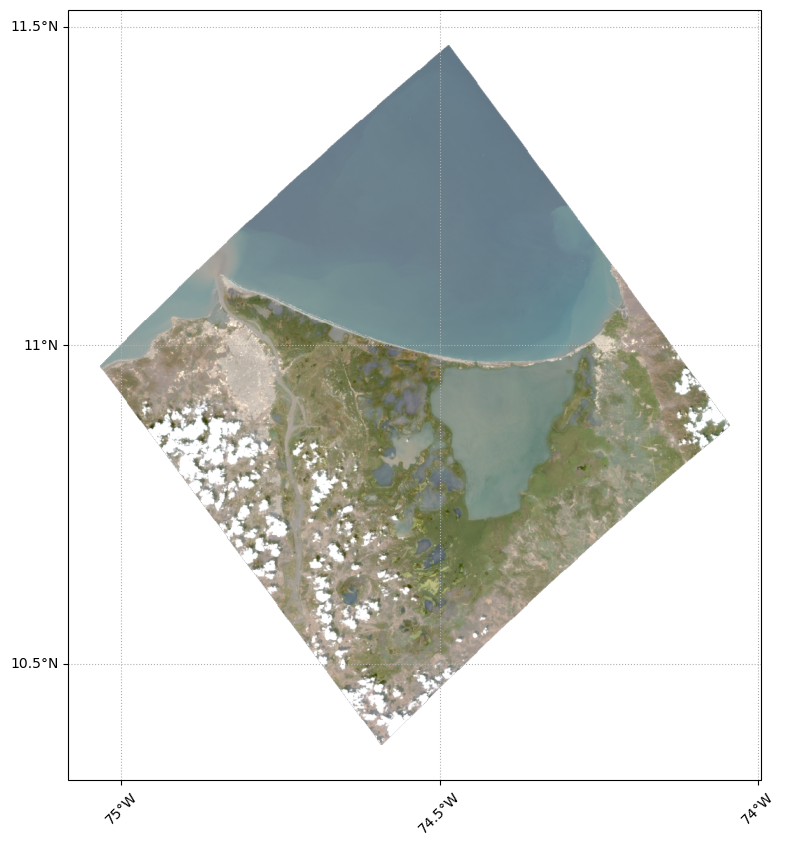

In [141]:
fig = plt.figure(figsize=(15, 10))

# use cartoee to get a map
ax = cartoee.get_map(img, vis_params=true_emit)

# pad the view for some visual appeal
cartoee.pad_view(ax)

# add the gridlines and specify that the xtick labels be rotated 45 degrees
cartoee.add_gridlines(ax, interval=0.5, xtick_rotation=45, linestyle=":")

# add the coastline
#ax.coastlines(color="yellow")

plt.show()

In [142]:
# Save the map as a standalone HTML file
#Map.save('emit_u2.html')
#html_file = 'emit_u2.html'
#Map.to_html(filename=html_file, title="EMIT composition", width="100%", height="880px")

See the map [here](https://htmlpreview.github.io/?https://github.com/ials/PR/blob/main/emit_u2.html)

## Using a hyperspectral toolkit

In [143]:
import emit_hyper

In [144]:
viz1b = {'bands': ['reflectance_164','reflectance_65','reflectance_37'], 
         'min': [-0.0730, -0.0834, -0.0684], 'max':[0.4050, 0.5376, 0.2140]}

In [145]:
Map.addLayer(img, viz1b, "02. EMIT false color")

In [152]:
fc = ee.FeatureCollection([ee.Feature(pt_ag)])

# Style: red, size 5 px
style = {
    "color": "FF0000",       # red hex
    "pointSize": 5,          # pixel size
    "pointShape": "circle",
}

styled = fc.style(**style)

In [156]:
Map.addLayer(st,{}, "Site")

EEException: Collection.style, argument 'color': Invalid type.
Expected type: String.
Actual type: Dictionary<Object>.
Actual value: {color=FF0000, pointShape=circle, pointSize=5}

In [148]:
Map

Map(center=[10.8689, -74.3822], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topr…

## Rename bands 

In [ ]:
## 4. Read and apply EMIT band names 
emit_bands = img.select(ee.List.sequence(0, 284)).bandNames()
emit_wavel = ee.List(img.get('reflectance_wavelengths'))

In [ ]:
emit_wavel

In [ ]:
## Use map() to iterate over the list and convert each number to a string and create new list.
def number(number):
    wavel = ee.String(number)
    return ee.String('SR_').cat(wavel.split('\\.').get(0))

In [ ]:
stringBands = emit_wavel.map(number)

In [ ]:
## Rename image with more intuitive band names
emit_renamed = img.select(emit_bands).rename(stringBands)
## If you want to check the new bands names:
new_emitB = emit_renamed.bandNames()

In [ ]:
new_emitB

## Plot spectral signature for a given region

In [ ]:
## 5. Now let's plot spectra for the given location

## Extract the pixel values.
spectral_values = (
    emit_renamed
    .select(new_emitB)
    .reduceRegion(
        reducer=ee.Reducer.first(),
        geometry=pt_ag,
        scale=60
    )
)

In [ ]:
## Convert spectral values to an array
values = ee.List(
    new_emitB.map(lambda band: spectral_values.get(band))
)

In [ ]:
import numpy as np

# values: ee.List of spectral values (from previous step)
# emit_wavel: ee.List of wavelengths (same length as values)

# Get server-side lists to client
vals = np.array(values.getInfo(), dtype=float)
wavs = np.array(emit_wavel.getInfo(), dtype=float)

# Optional: restrict wavelength range, e.g. 400–900 nm
mask = (wavs >= 400) & (wavs <= 900)
wavs_plot = wavs[mask]
vals_plot = vals[mask]

# Plot
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(wavs_plot, vals_plot, color='black', linewidth=1)
ax.set_title('EMIT - Spectral Profile at Point')
ax.set_xlabel('Wavelength nm')
ax.set_ylabel('Reflectance')
ax.set_xlim(400, 900)   # viewWindow min/max
ax.grid(False)

plt.show()
